# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 31.9 s, sys: 120 ms, total: 32 s
Wall time: 32.8 s


Parse works cited section of the `README.md` document for more analysis information.

In [7]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [9]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [13]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,21
organization,17
article,34
codes,159
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [3]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [4]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[use public disclosure data, format table disp...",0,24,"count number of records, plot histogram, peek ..."
1,6,2019-04-democratic-candidate-codonors,"[use public disclosure data, use tabular data,...",1,44,"calculate scaled ratio, export intermediate re..."
2,14,california-crop-production-wages-analysis,"[use public disclosure data, format table disp...",3,47,"adjust for inflation, construct table manually..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,51,"use public data, slice column values, use geos..."
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,61,"left join tables, scrape web for data, join wi..."


Plot the size of the code set as more computational notebooks are analyzed.

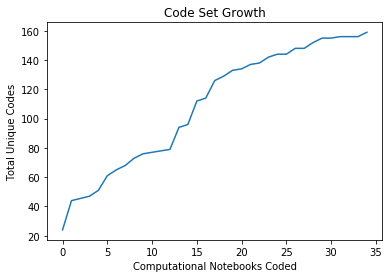

In [14]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [15]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: count number of records, plot histogram, peek at data, change column data type, use tabular data, inner join tables, count value frequency, calculate mean, remove incomplete data, drop entirely duplicate rows, use public disclosure data, repetitive code, drop columns, calculate difference, inspect table schema, sort table, export results, split, compute, and merge, adjust for season, group by single column, calculate z-score, format table display, calculate percentage difference, filter rows

2. **2019-04-democratic-candidate-codonors**: calculate scaled ratio, export intermediate results, change case, prevent double-counting, union tables, canonicalize column names, annotate workflow, strip whitespace, self join table, use structured ascii, sum column values, architect a subroutine, create a semi-unique key, merge metadata, count unique values in column, group by multiple columns, remove with regular expression, right join tables, calculate ratio, gather table

3. **california-crop-production-wages-analysis**: adjust for inflation, construct table manually, architect repeating process

4. **census-hard-to-map-analysis**: use public data, slice column values, use geospatial data, wrangle data for graphics

5. **long-term-care-db**: left join tables, scrape web for data, join with lookup table, drop rows with duplicate value in one column, drop erroneous rows, construct pivot table, perform name entity resolution manually, use non-public, provided data, fix data errors manually, encode table identification in row

6. **2018-voter-registration**: plot stacked bar chart, pull tables out of pdf, plot stacked column chart, extract single value

7. **heat_and_humidity**: generate data computationally, compute index number, cartesian product

8. **2016-11-bellwether-counties**: calculate spread, spread table, get max value, create rolling window, use academic data

9. **2018-05-31-crime-and-heat-analysis**: combine seemingly disparate datasets, extract property from datetime, plot scatterplot

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: add calculated column from axillary data

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: remove all rows but the master record, plot column chart, encoding provenance in data, display entire table, geocode addresses, temporary joining column, cache results from external service, trim by geographic area, trim by date range, create a unique key, omits data quality exploration, create a crosstab, replace na values, split and compute, preserve existing values

14. **Endangered-Species-Act-Louisiana**: perform scalar multiplication, plot trendline

15. **Power_of_Irma**: find worst offender, set data confidence threshold, plot boxplot, fix incorrect calculation, plot violin plot, look for trends, tolerate dirty data, select columns, find most frequently occurring, log-ify values, use previously cleaned data, value replacement, use data from colleague, fit a generalized linear model, change date format, toggle step on and off

16. **wikipedia-rankings**: plot scree plot, analyze principle components

17. **babyname_politics**: natural join, peel and merge, data loss from aggregation, round floating point, encode table summary data in row, trim by quantitative threshold, get unique values, resort after merge, assign ranks, check results of previous operation, concatenate columns into key, break ties

18. **2015-11-refugees-in-the-united-states**: make an incorrect conclusion, compare total number of rows, designate column as primary key

19. **employment-discrimination**: align table columns for consolidation, combine entities by string matching, merge tables to create pivot table, concatenate files together

20. **bechdel**: calculate median

21. **bob-ross**: collect raw data, run cluster analysis, whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: create flag, test for equality, data too large for repo, translate entity names manually

24. **buster-posey-mvp**: plot line chart, image analysis

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: filter by contains value, sort table rows, report rows with column number discrepancies, remove delimiting characters

27. **prison-admissions**: 

28. **school-star-ratings-2018**: display rows with errors, get min value, reconcile primary keys between tables, pad column values

29. **electric-car-charging-points**: add foreign key column, define edge weights, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: create a table to lookup values, resolve to arbitrary entity name among choices, outer join tables

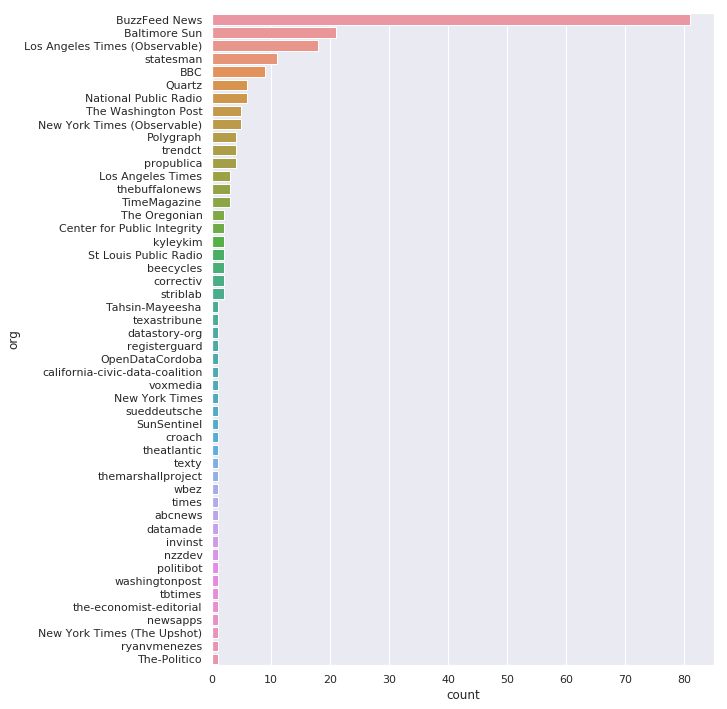

In [18]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org', 
              data=keepers,
              order=keepers.org.value_counts().index)